# **Tutorial 6: Scenario-dependence of Future Changes in Extremes**

**Week 2, Day 4, Extremes & Vulnerability**

**Content creators:** Matthias Aengenheyster, Joeri Reinders

**Content reviewers:** Younkap Nina Duplex, Sloane Garelick, Zahra Khodakaramimaghsoud, Peter Ohue, Laura Paccini, Jenna Pearson, Agustina Pesce, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In this tutorial, we will analyze climate model output for various cities worldwide to investigate the changes in extreme temperature and precipitation patterns over time under different emission scenarios.

The data we will be using consists of climate model simulations for the historical period and three future climate scenarios:

1. Historical (hist): This scenario covers the time range from 1851 to 2014 and incorporates information about volcanic eruptions, greenhouse gas emissions, and other factors relevant to historical climate conditions.
The SSP scenarios represent potential climate futures beyond 2014. It's important to note that these scenarios are predictions ("this is what we think will happen") but are not certainties ("this is plausible given the assumptions"). Each scenario is based on different assumptions, primarily concerning the speed and effectiveness of global efforts to address global warming and reduce greenhouse gas emissions and other pollutants.
2. SSP-126: This is an "ambitious" climate scenario characterized by rapid emission reductions, leading to relatively low levels of global warming and climate impacts.
3. SSP-245: This is a "medium" climate scenario that reflects a plausible trajectory based on current policies and assumptions about political behavior.
4. SSP-585: This is the most extreme climate scenario considered by the IPCC, projecting strong economic growth driven by greenhouse gas emissions. It exhibits the highest level of warming among all scenarios and is often used as a "worst-case scenario" (though it may not be the most likely outcome). It is worth noting that many experts today consider this scenario to be unlikely due to significant improvements in mitigation policies over the past decade or so.

By the end of this tutorial, you will gain the following abilities:

- Utilize climate model output from scenario runs to assess changes during the historical period.
- Compare potential future climate scenarios, focusing on their impact on extreme events.

# **Setup**

In [1]:
# google colab installs
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [2]:
# imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cartopy.crs as ccrs
from scipy import stats
from datetime import datetime
import os
import pooch

In [3]:
def estimate_return_level(quantile,loc,scale,shape):
    level = loc + scale / shape * (1 - (-np.log(quantile))**(shape))
    return level

In [4]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [5]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# **Section 1: Load CMIP6 Data**

In [6]:
# download file: 'cmip6_data_city_daily_scenarios_tasmax_pr_models.nc'
url_cmip6_data = "https://osf.io/ngafk/download"
data = xr.open_dataset(pooch.retrieve(url_cmip6_data, known_hash=None))

SHA256 hash of downloaded file: ec51d1c9a8eb97e4506107be1b7aa36939d87762cb590cf127c6ce768b75c609
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


### Through pangeo

The commented code boxes below recreate the data loaded in the previous line.

It has been commented out as this code is NOT NECESSARY for this tutorial to run. Please DO NOT run it straightaway, the code takes quite long time to run and uses significant computing resources. However, the code is provided to give a better idea of how data can be obtained through [Pangeo](https://pangeo.io/) - which is an immensely valuable resource we have introduced previously. 

In this way you can access large amounts of climate model output that has been stored in the cloud. This is very useful to get easy access to such information. Feel free to modify the code to access different data and address your own questions.

In [16]:
# import intake 
# from xmip.preprocessing import combined_preprocessing
# from xarrayutils.plotting import shaded_line_plot

# from xmip.utils import google_cmip_col
# # we could do all of this with pure pandas on the underlying csv file
# col = google_cmip_col()

In [17]:
# cat = col.search(
#     source_id=['MPI-ESM1-2-HR','MIROC6'],
#     variable_id=['pr','tas'],
#     member_id='r1i1p1f1', #
#     table_id='day',
#     grid_label='gn',
#     experiment_id = ['historical','ssp126', 'ssp245', 'ssp585'],
#     require_all_on = ['experiment_id','variable_id']
# )
# kwargs = dict(preprocess=combined_preprocessing, xarray_open_kwargs=dict(use_cftime=True))
# ds_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})

Define one or more locations

In [18]:
# sel_Hamburg = dict(lon=10,lat=53.5)
# sel_Madrid = dict(lon=360-42,lat=40.5)
# sel_Delhi = dict(lon=77,lat=28.5)
# sel_Kinshasa = dict(lon=15,lat=-4)
# sel_Phoenix = dict(lon=360-112,lat=33.5)
# sel_Sydney = dict(lon=151,lat=-33.85)

# sels = dict(
#     Hamburg = sel_Hamburg,
#     Madrid = sel_Madrid,
#     Delhi = sel_Delhi,
#     Kinshasa = sel_Kinshasa,
#     Phoenix = sel_Phoenix,
#     Sydney = sel_Sydney
# )

Assemble your data

In [19]:
# models = []
# model_dict = {}
# for k in ds_dict.keys():
#     string = k.split('.')
#     model = string[2]
#     models.append(model)
#     scenario = string[3]
#     print(string, model, scenario)
#     model_dict['%s.%s' % (model,scenario)] = k

# models = ['MPI-ESM1-2-HR', 'MIROC6']
# scenarios = ['ssp126','ssp245','ssp585']
# outs = []
# for model in models:
#     outsm = []
#     for city in sels.keys():
#         outis = []
#         for scenario in scenarios:
#             timeseries = xr.concat(
#                         [
#                             ds_dict[model_dict['%s.%s' % (model, 'historical')]].sel(sels[city],method='nearest').sel(time=slice('2014')),
#                             ds_dict[model_dict['%s.%s' % (model, scenario)]].sel(time=slice('2100')).sel(sels[city],method='nearest')
#                             # ds_dict['%s.%s' % (model, 'historical')].sel(sels[city],method='nearest').sel(time=slice('2014')),
#                             # ds_dict['%s.%s' % (model, scenario)].sel(sels[city],method='nearest')
#                         ],'time'
#                         )
#             timeseries = timeseries.assign_coords(city=city,scenario=scenario,model=model).squeeze()
#             outis.append(timeseries)
#             # outis.append(ds_dict[key].sel(sels[city],method='nearest').assign_coords(city=city,scenario=key).squeeze())
#         outsm.append(xr.concat(outis,'scenario'))
#     outs.append(xr.concat(outsm,'city'))
# data = xr.concat(outs,'model')

In [20]:
# print('The data has %.3f MB' % data.nbytes / 1e6)
# print('The next line triggers the computation!')
# #with ProgressBar():
# #     data.load()

# Fix time axis
# data = out2.assign_coords(time=pd.to_datetime(data.time))
# # Convert precip data to mm/day
# data['pr'] = data['pr'] * 86400
# data['pr'].attrs = data['pr'].attrs
# data['pr'].attrs['units'] = 'mm/day'

# **Section 2: Inspect Data**

In [8]:
data

<xarray.Dataset>
Dimensions:         (model: 2, city: 6, bnds: 2, scenario: 3, time: 91676)
Coordinates:
    lat             (model, city) float64 ...
    lat_bnds        (model, city, bnds) float64 ...
    lon             (model, city) float64 ...
    lon_bnds        (model, city, bnds) float64 ...
  * time            (time) datetime64[ns] 1850-01-01T12:00:00 ... 2100-12-31T...
    time_bnds       (time, bnds) datetime64[ns] ...
    member_id       object ...
    dcpp_init_year  float64 ...
    height          float64 ...
  * city            (city) object 'Hamburg' 'Madrid' ... 'Phoenix' 'Sydney'
  * scenario        (scenario) object 'ssp126' 'ssp245' 'ssp585'
  * model           (model) object 'MPI-ESM1-2-HR' 'MIROC6'
Dimensions without coordinates: bnds
Data variables:
    pr              (model, city, scenario, time) float64 ...
    tasmax          (model, city, scenario, time) float32 ...
Attributes: (12/56)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        day
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.day.gn

### Excercise:
Describe the data in your own words. What kind of data is available? In terms of variables, models, spatial location, time range, time resolution, scenarios?

In [9]:
# to_remove explanation
"""
Put your observations here
"""

'\nPut your observations here\n'

# **Section 3: Processing**

Let's look at the data for one selected city, for one climate model. In this case here, we choose Madrid and `MPI-ESM1-2-HR` model.

In [11]:
city = 'Madrid'
data_city = data.sel(city=city,model='MPI-ESM1-2-HR')


In [12]:
data_city

<xarray.Dataset>
Dimensions:         (bnds: 2, scenario: 3, time: 91676)
Coordinates:
    lat             float64 ...
    lat_bnds        (bnds) float64 ...
    lon             float64 ...
    lon_bnds        (bnds) float64 ...
  * time            (time) datetime64[ns] 1850-01-01T12:00:00 ... 2100-12-31T...
    time_bnds       (time, bnds) datetime64[ns] ...
    member_id       object ...
    dcpp_init_year  float64 ...
    height          float64 ...
    city            <U6 'Madrid'
  * scenario        (scenario) object 'ssp126' 'ssp245' 'ssp585'
    model           <U13 'MPI-ESM1-2-HR'
Dimensions without coordinates: bnds
Data variables:
    pr              (scenario, time) float64 ...
    tasmax          (scenario, time) float32 ...
Attributes: (12/56)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        day
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.day.gn

The data has daily resolution, for three climate scenarios. Until 2014 the scenarios are identical (the 'historical' scenario). After 2014 they are diverge given different climate change trajectories.

(0.0, 106.01652665063739)

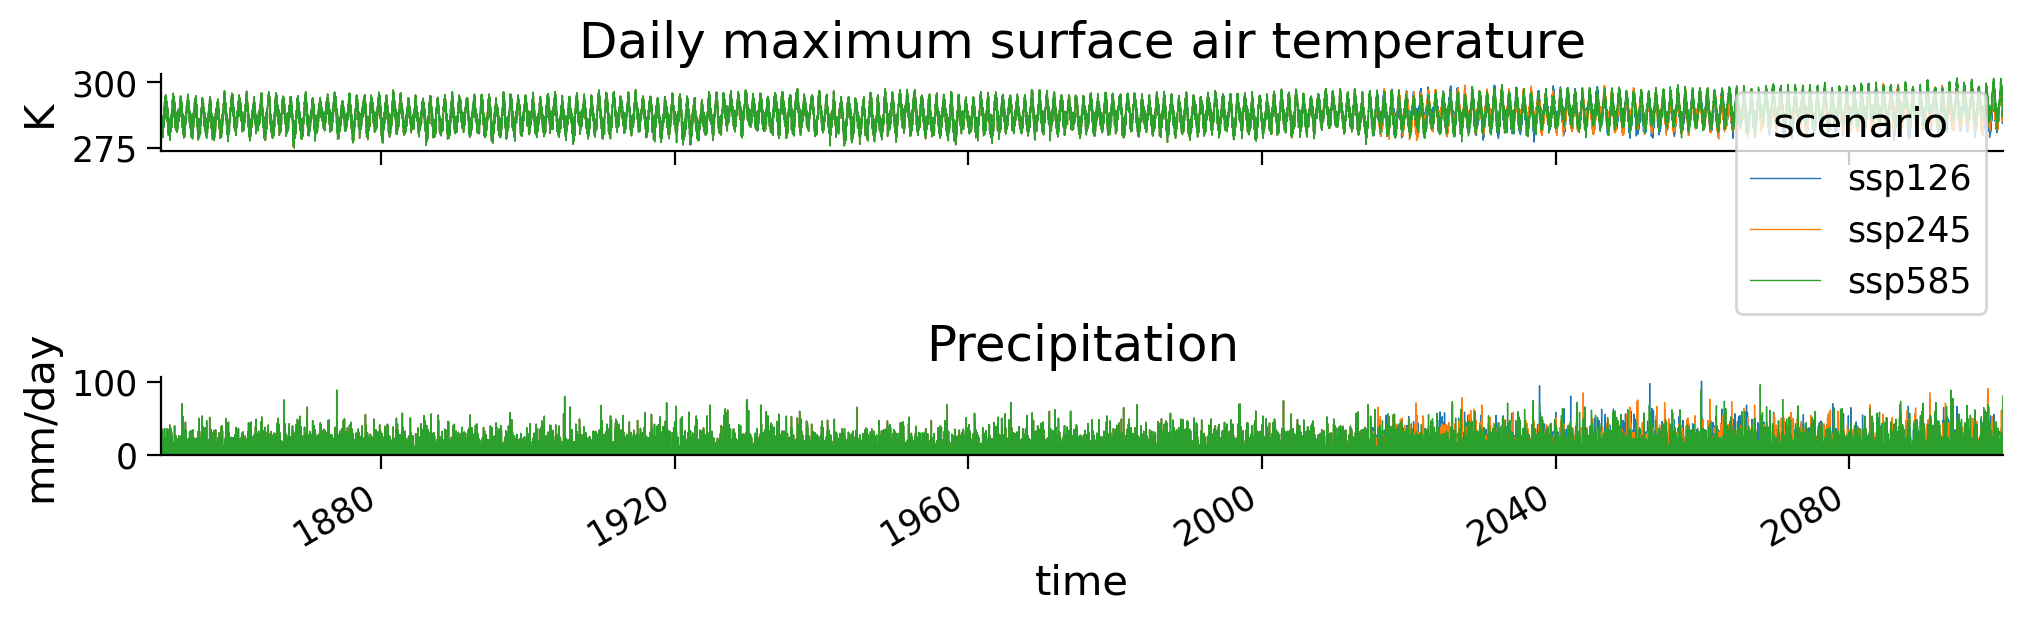

In [13]:
fig, ax = plt.subplots(2,sharex=True,figsize=(10,3),constrained_layout=True)
data_city['tasmax'].plot(hue='scenario',ax=ax[0],lw=0.5)
data_city['pr'].plot(hue='scenario',ax=ax[1],lw=0.5,add_legend=False)

ax[0].set_title('Daily maximum surface air temperature')
ax[1].set_title('Precipitation')

ax[0].set_xlabel('')

ax[0].set_ylabel('K')
ax[1].set_ylabel('mm/day')

ax[0].set_xlim(
    datetime(1850,1,1),
    datetime(2100,12,31)
)

ax[1].set_ylim(0,None)

In the previous tutorials we have been operating on annual maxima data - looking at the most extreme event observed in each year. We will do the same here: take the day in each year with the highest temperature or the largest amount of rainfall

(0.0, 104.62553188204765)

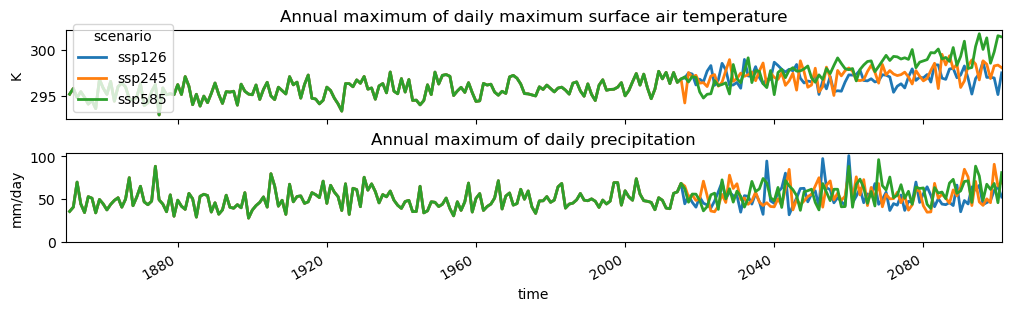

In [10]:
fig, ax = plt.subplots(2,sharex=True,figsize=(10,3),constrained_layout=True)
data_city['tasmax'].resample(time='1Y').max().plot(hue='scenario',ax=ax[0],lw=2)
data_city['pr'].resample(time='1Y').max().plot(hue='scenario',ax=ax[1],lw=2,add_legend=False)

ax[0].set_title('Annual maximum of daily maximum surface air temperature')
ax[1].set_title('Annual maximum of daily precipitation')

ax[0].set_xlabel('')

ax[0].set_ylabel('K')
ax[1].set_ylabel('mm/day')

ax[0].set_xlim(
    datetime(1850,1,1),
    datetime(2100,12,31)
)

ax[1].set_ylim(0,None)

## **Questions 3** 
1. Describe the plot - what do you see for the two variables, over time, between scenarios?

In [28]:
# to_remove explanation
"""
variations between scenarios for both surface air temp and daily precipitation, while the variations between scenarios are larger in surface air temp
"""

'\nvariations between scenarios for both surface air temp and daily precipitation, while the variations between scenarios are larger in surface air temp\n'

# **Section 4: Differences Between Historical Periods:**

Let's focus on precipitation for now, and compute the maximum for each year. As in the previous tutorial we want to compare consecutive 30-year periods in the past: therefore take the historical run (1850-2014), and look at the last three 30-year periods. We only need to look at one scenario because they all use the historical run until 2014.

In [14]:
pr_city = data_city['pr']
pr_city_max= pr_city.resample(time='1Y').max()

data_period1 = pr_city_max.sel(scenario='ssp245',time=slice('2014')).sel(time=slice('1925','1954')).to_dataframe()['pr']
data_period2 = pr_city_max.sel(scenario='ssp245',time=slice('2014')).sel(time=slice('1955','1984')).to_dataframe()['pr']
data_period3 = pr_city_max.sel(scenario='ssp245',time=slice('2014')).sel(time=slice('1985','2014')).to_dataframe()['pr']

Plot the histograms of annual maximum daily precipitation for the three periods. What do you see? Compare to the analysis in the previous tutorial where we analyzed sea level height. Any similarities or differences? Why do you think that is?

Text(0.5, 0, 'annual maximum daily precipitation (mm/day)')

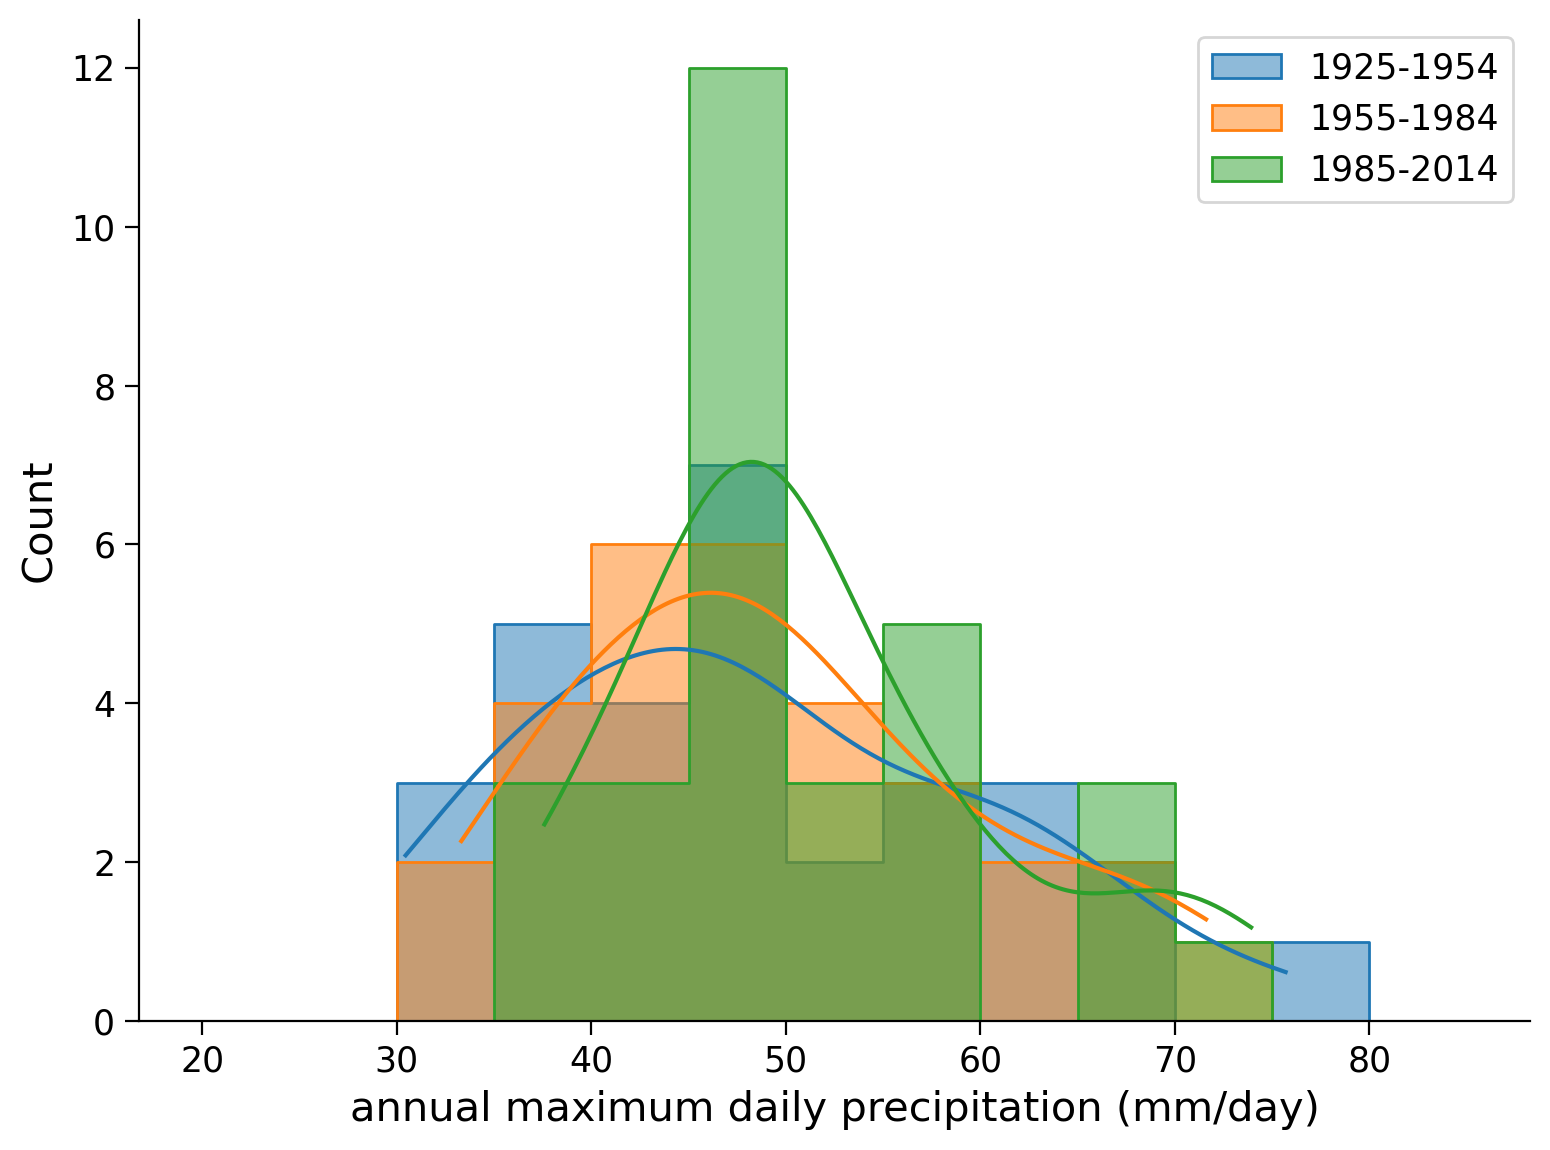

In [15]:
fig,ax=plt.subplots()
sns.histplot(data_period1,bins=np.arange(20,90,5),color='C0',element='step',alpha=0.5,kde=True,label='1925-1954',ax=ax)
sns.histplot(data_period2,bins=np.arange(20,90,5),color='C1',element='step',alpha=0.5,kde=True,label='1955-1984',ax=ax)
sns.histplot(data_period3,bins=np.arange(20,90,5),color='C2',element='step',alpha=0.5,kde=True,label='1985-2014',ax=ax)
ax.legend()
ax.set_xlabel('annual maximum daily precipitation (mm/day)')

In [16]:
periods_stats = pd.DataFrame(index=['Mean','Standard Deviation','Skew'])
periods_stats['1925-1954'] = [data_period1.mean(), data_period1.std(), data_period1.skew()]
periods_stats['1955-1984'] = [data_period2.mean(), data_period2.std(), data_period2.skew()]
periods_stats['1985-2014'] = [data_period3.mean(), data_period3.std(), data_period3.skew()]

periods_stats = periods_stats.T
periods_stats

,Mean,Standard Deviation,Skew
1925-1954,48.430939,11.521903,0.485490
1955-1984,49.461359,10.390394,0.547118
1985-2014,51.412866,9.354812,0.905246


Now, we fit a GEV to the three time periods, and plot the distributions using the gev.pdf function:

In [17]:
gev = stats.genextreme
gev.fit(data_period1.values)

(0.09307355209208032, 43.51828403778693, 9.769295887460995)

In [18]:
params_period1 = gev.fit(data_period1,0)
shape_period1, loc_period1, scale_period1 = params_period1
params_period2 = gev.fit(data_period2,0)
shape_period2, loc_period2, scale_period2 = params_period2
params_period3 = gev.fit(data_period3,0)
shape_period3, loc_period3, scale_period3 = params_period3

Text(0, 0.5, 'Density')

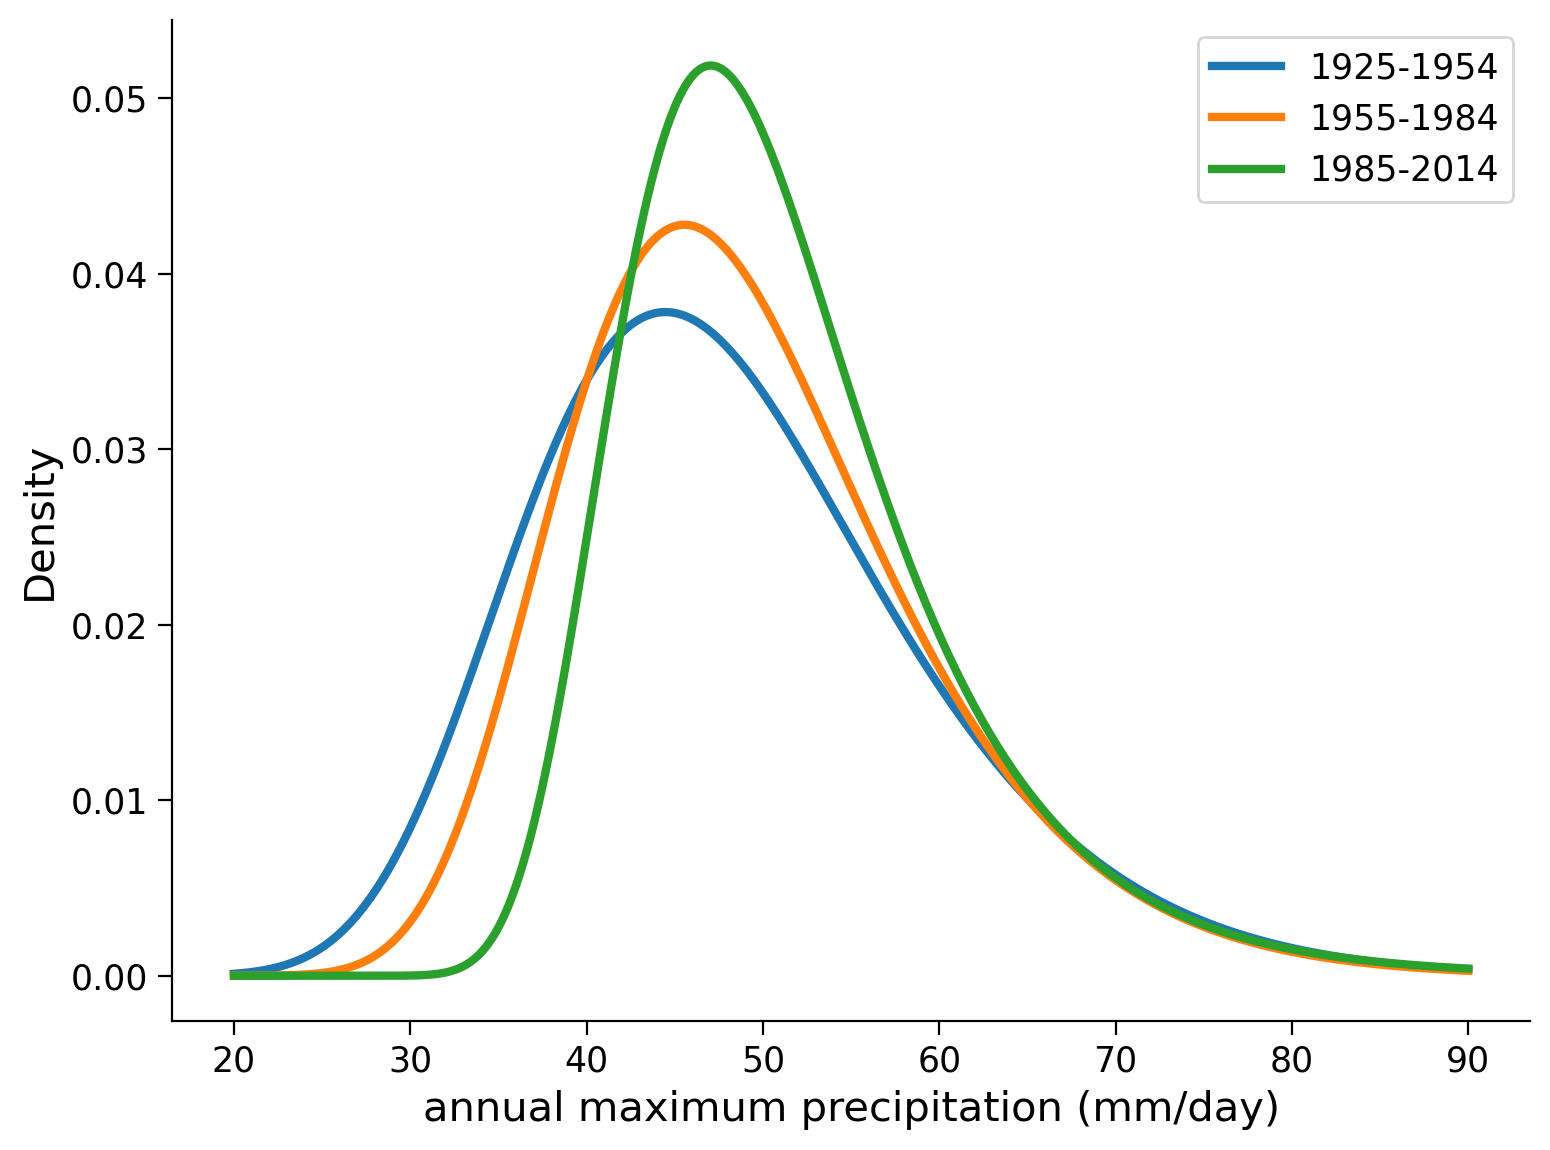

In [19]:
fig, ax = plt.subplots()
x = np.linspace(20,90,1000)
ax.plot(x,gev.pdf(
    x,shape_period1,
    loc=loc_period1,scale=scale_period1
    ),
    c='C0',lw=3,label='1925-1954')
ax.plot(x,gev.pdf(
    x,shape_period2,
    loc=loc_period2,scale=scale_period2
    ),
    c='C1',lw=3,label='1955-1984')
ax.plot(x,gev.pdf(
    x,shape_period3,
    loc=loc_period3,scale=scale_period3
    ),
    c='C2',lw=3,label='1985-2014')
ax.legend()
ax.set_xlabel('annual maximum precipitation (mm/day)')
ax.set_ylabel('Density')

In [20]:
parameters = pd.DataFrame(index=['Location', 'Scale', 'Shape'])
parameters['1925-1954'] = [loc_period1, scale_period1, shape_period1]
parameters['1955-1984'] = [loc_period2, scale_period2, shape_period2]
parameters['1985-2014'] = [loc_period3, scale_period3, shape_period3]

parameters = parameters.T
parameters.round(4)#.astype('%.2f')

,Location,Scale,Shape
1925-1954,43.5183,9.7693,0.0931
1955-1984,44.9420,8.6153,0.0673
1985-2014,47.1629,7.0925,-0.0177


Create a return level plot for the three periods. You may use the functions below, in particular `fit_return_levels` to generate an xr.Dataset that contains empirical and GEV fits, as well as confidence intervals, and `plot_return_levels` to generate a plot from this xr.Dataset.

These functions can also be found in gev_functions (`import gev_functions as gf`).

What do you conclude for the historical change in extreme precipitation in this city? What possible limitations could this analysis have? (How) could we address this?

In [22]:
def estimate_return_level_period(period,loc,scale,shape):
    '''
    Compute GEV-based return level for a given return period, and GEV parameters
    '''
    return stats.genextreme.ppf(1-1/period,shape,loc=loc,scale=scale)

def empirical_return_level(data):
    '''
    Compute empirical return level using the algorithm introduced in Tutorial 2
    '''
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df['sorted'] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df['ranks_sp'] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df['exceedance'] = df['ranks_sp']/(n+1)
    # find return period
    df['period'] = 1 / df['exceedance']

    df = df[::-1]

    out = xr.DataArray(
        dims=['period'],
        coords={'period':df['period']},
        data=df['sorted'],name='level')
    return out

def fit_return_levels(data,years,N_boot=None,alpha=0.05):
    '''
    Fit GEV to data, compute return levels and confidence intervals
    '''
    empirical = empirical_return_level(data).rename({'period':'period_emp'}).rename('empirical')
    shape, loc, scale = gev.fit(data,0)
    print('Location: %.1e, scale: %.1e, shape: %.1e' % (loc, scale, shape))
    central = estimate_return_level_period(years,loc,scale,shape)

    out = xr.Dataset(
        # dims = ['period'],
        coords = {
            'period': years,
            'period_emp': empirical['period_emp']
            },
        data_vars={
            'empirical':(['period_emp'],empirical.data),
            'GEV':(['period'],central)
            }
    )

    if N_boot:
        levels = []
        shapes, locs, scales = [],[],[]
        for i in range(N_boot):
            datai = np.random.choice(data,size=data.size,replace=True)
            # print(datai.mean())
            shapei,loci,scalei = gev.fit(datai,0)
            shapes.append(shapei)
            locs.append(loci)
            scales.append(scalei)
            leveli = estimate_return_level_period(years,loci,scalei,shapei)
            levels.append(
                leveli
            )

        levels = np.array(levels)
        quant = alpha / 2, 1-alpha/2
        quantiles = np.quantile(levels,quant,axis=0)

        print('Ranges with alpha=%.3f :' % alpha)
        print('Location: [%.2f , %.2f]'  % tuple(np.quantile(locs,quant).tolist()))
        print('Scale: [%.2f , %.2f]'  % tuple(np.quantile(scales,quant).tolist()))
        print('Shape: [%.2f , %.2f]'  % tuple(np.quantile(shapes,quant).tolist()))

        quantiles = xr.DataArray(
            dims=['period','quantiles'],
            coords={'period':out.period,'quantiles':np.array(quant)},
            data=quantiles.T
        )
        out['range'] = quantiles
    return out

def plot_return_levels(obj,c='C0',label='',ax=None):
    '''
    Plot fitted data:
        - empirical return level
        - GEV-fitted return level
        - alpha-confidence ranges with bootstrapping (if N_boot is given)
    '''
    if not ax:
        ax = plt.gca()
    obj['GEV'].plot.line('%s-' % c,lw=3,_labels=False,label=label,ax=ax)
    obj['empirical'].plot.line('%so' % c,mec='k',markersize=5,_labels=False,ax=ax)
    if 'range' in obj:
        # obj['range'].plot.line('k--',hue='quantiles',label=obj['quantiles'].values)
        ax.fill_between(obj['period'],*obj['range'].T,alpha=0.3,lw=0,color=c) 
    ax.semilogx()
    ax.legend()

In [23]:
fit_period1 = fit_return_levels(data_period1,np.arange(1.1,1000,0.1),N_boot=100,alpha=0.05)
fit_period2 = fit_return_levels(data_period2,np.arange(1.1,1000,0.1),N_boot=100,alpha=0.05)
fit_period3 = fit_return_levels(data_period3,np.arange(1.1,1000,0.1),N_boot=100,alpha=0.05)

Location: 4.4e+01, scale: 9.8e+00, shape: 9.3e-02
Ranges with alpha=0.050 :
Location: [38.51 , 48.66]
Scale: [6.64 , 13.21]
Shape: [-0.32 , 0.43]
Location: 4.5e+01, scale: 8.6e+00, shape: 6.7e-02
Ranges with alpha=0.050 :
Location: [41.11 , 48.35]
Scale: [5.89 , 11.37]
Shape: [-0.22 , 0.37]
Location: 4.7e+01, scale: 7.1e+00, shape: -1.8e-02
Ranges with alpha=0.050 :
Location: [45.24 , 49.67]
Scale: [4.75 , 9.06]
Shape: [-0.20 , 0.22]


Text(0, 0.5, 'return level (mm/day)')

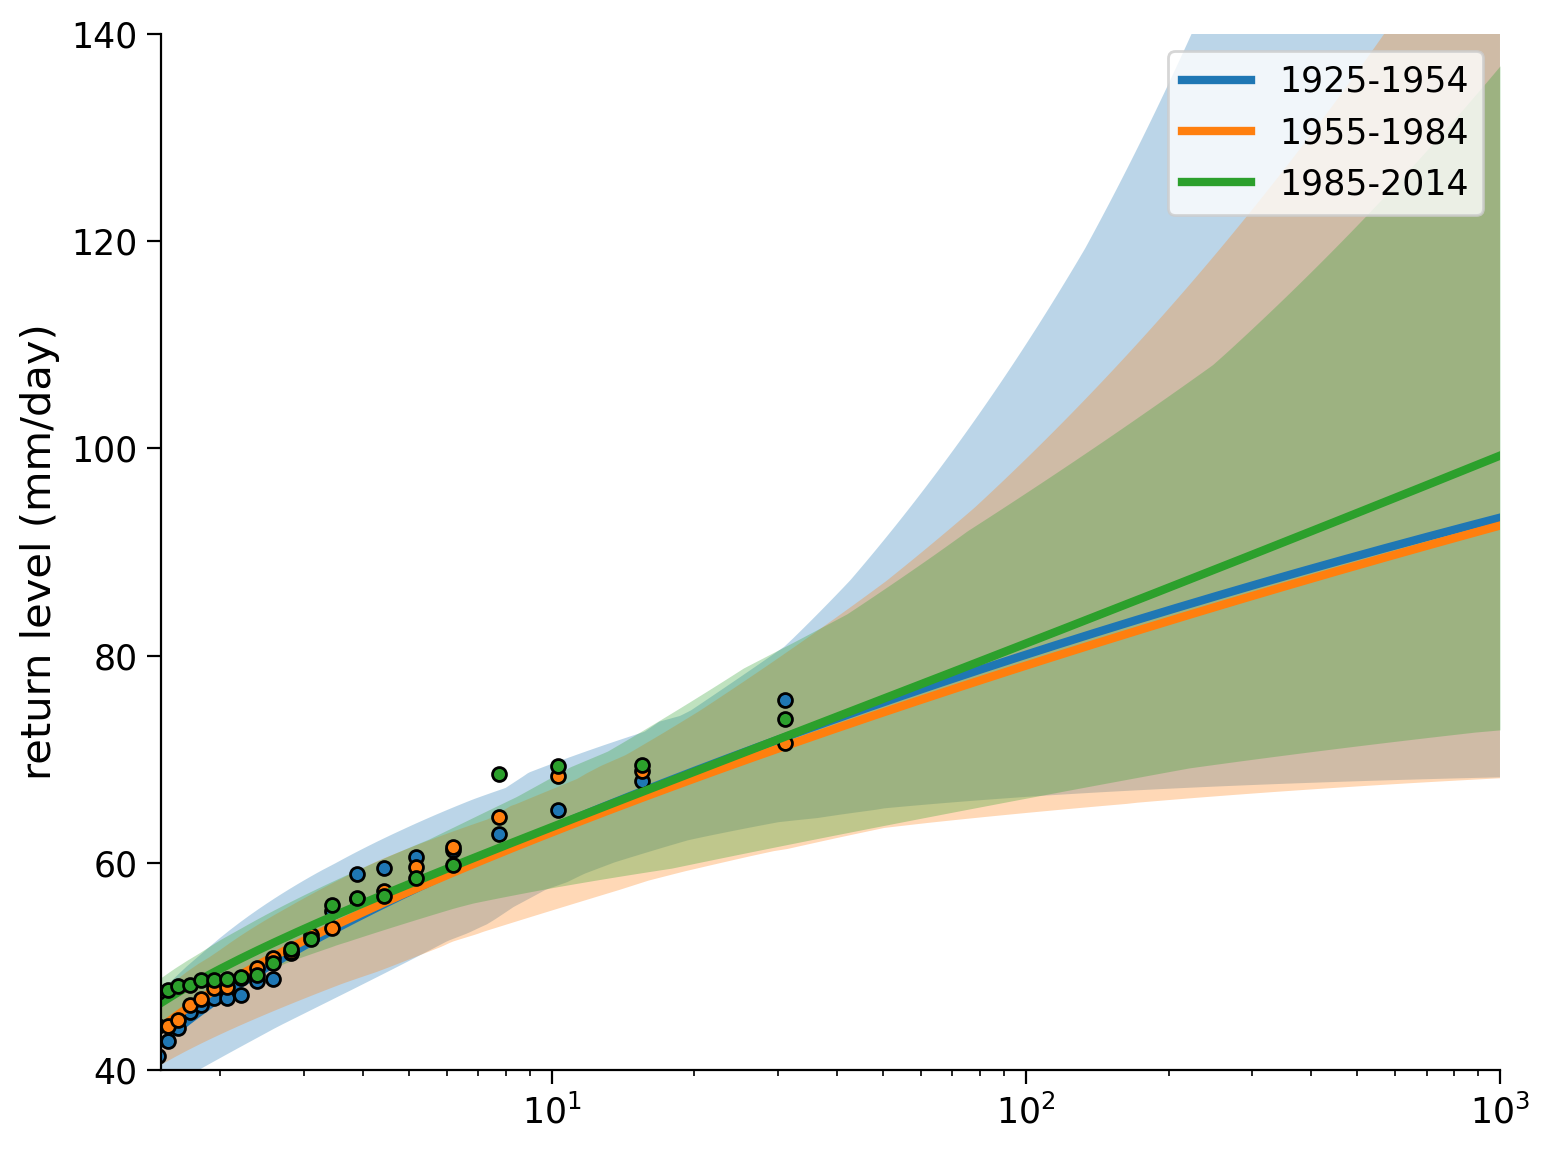

In [25]:
fig, ax= plt.subplots()
plot_return_levels(fit_period1,c='C0',label='1925-1954',ax=ax)
plot_return_levels(fit_period2,c='C1',label='1955-1984',ax=ax)
plot_return_levels(fit_period3,c='C2',label='1985-2014',ax=ax)
ax.set_xlim(1.5,1000)
ax.set_ylim(40,140)

ax.legend()
ax.set_ylabel('return level (mm/day)')

Now let's look at hot days in possible climate futures: the years 2071-2100 (the last 30 years). For comparison we use the historical period, 1850-2014 - where we use the entire 165 years because it gives us much nicer statistics!

In the next box we select the data:

In [29]:
data_city = data.sel(city=city,model='MPI-ESM1-2-HR')
# data_city = data.sel(city=city,model='MIROC6')
data_city_fut  = data_city['pr'].sel(time=slice('2071','2100')).resample(time='1Y').max()

# select the different time periods
data_hist = data_city['pr'].sel(scenario='ssp126',time=slice('1850','2014')).resample(time='1Y').max().to_dataframe()['pr']
data_ssp126 = data_city_fut.sel(scenario='ssp126').to_dataframe()['pr']
data_ssp245 = data_city_fut.sel(scenario='ssp245').to_dataframe()['pr']
data_ssp585 = data_city_fut.sel(scenario='ssp585').to_dataframe()['pr']

## **Coding Exercises 4**
Differences between climate scenarios:

Repeat the analysis that we did above for three different time periods, now for three different climate scenarios, and the historical period for comparison.
1. Create a figure that displays the histograms of the four records. Find a useful number and spacing of bins (via the bins= keyword to sns.histplot). Think what the comparison tells you.
2. Fit GEV distributions to the four records using the same commands as above. Use the `gev.pdf` function to plot the fitted distributions.
3. Inspect location, scale and shape parameters
4. Create a return-level plot using the `ef.plot_levels_from_obj` function.

Text(0.5, 0, 'annual maximum daily precipitation (mm/day)')

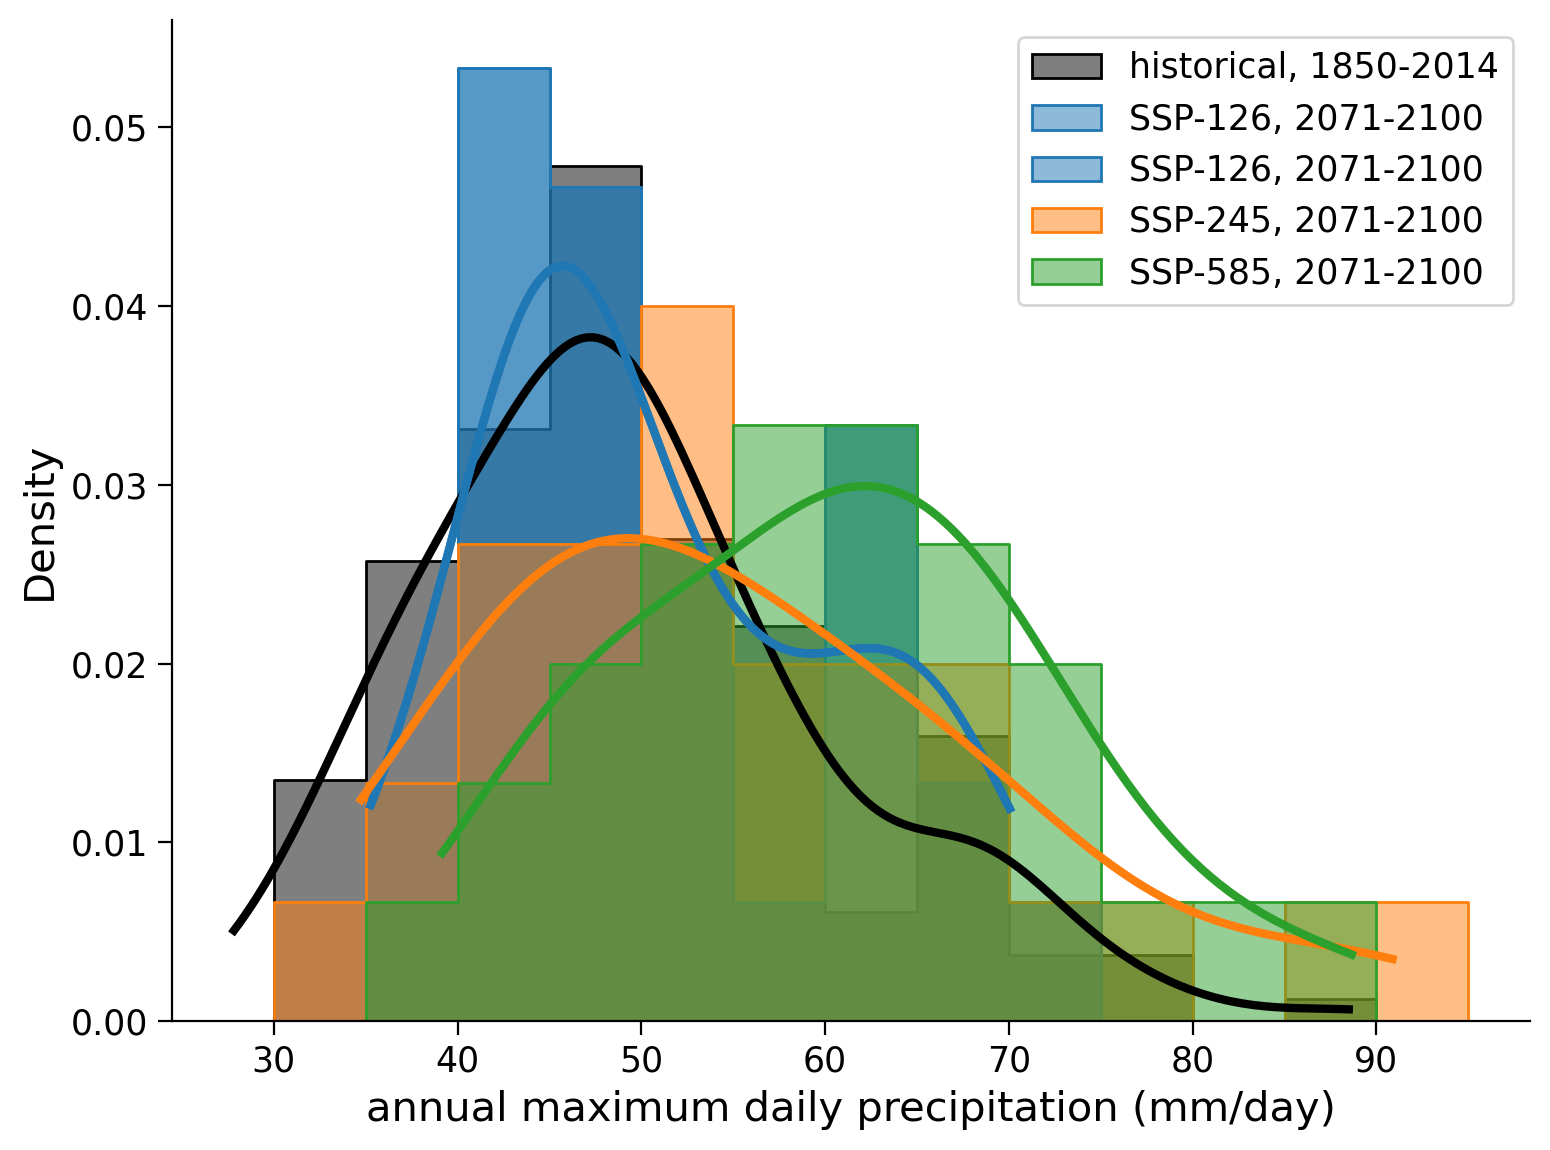

In [27]:
fig,ax = plt.subplots()
sns.histplot(data_hist,bins=np.arange(30,100,5),color='k',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='historical, 1850-2014',ax=ax)
sns.histplot(data_ssp126,bins=np.arange(30,100,5),color='C0',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-126, 2071-2100',ax=ax)
sns.histplot(data_ssp126,bins=np.arange(30,100,5),color='C0',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-126, 2071-2100',ax=ax)
sns.histplot(data_ssp245,bins=np.arange(30,100,5),color='C1',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-245, 2071-2100',ax=ax)
sns.histplot(data_ssp585,bins=np.arange(30,100,5),color='C2',element='step',stat='density',alpha=0.5,line_kws=dict(lw=3),kde=True,label='SSP-585, 2071-2100',ax=ax)
ax.legend()

ax.set_xlabel('annual maximum daily precipitation (mm/day)')

In [30]:
periods_stats = pd.DataFrame(index=['Mean','Standard Deviation','Skew'])
periods_stats['hist'] = [data_hist.mean(), data_hist.std(), data_hist.skew()]
periods_stats['ssp126'] = [data_ssp126.mean(), data_ssp126.std(), data_ssp126.skew()]
periods_stats['ssp245'] = [data_ssp245.mean(), data_ssp245.std(), data_ssp245.skew()]
periods_stats['ssp585'] = [data_ssp585.mean(), data_ssp585.std(), data_ssp585.skew()]

periods_stats = periods_stats.T
periods_stats

,Mean,Standard Deviation,Skew
hist,49.269219,11.119333,0.693951
ssp126,51.130332,9.557283,0.476350
ssp245,55.264835,14.017823,0.764946
ssp585,60.534207,11.782039,0.276712


In [31]:
shape_hist, loc_hist, scale_hist = gev.fit(data_hist)
shape_ssp126, loc_ssp126, scale_ssp126 = gev.fit(data_ssp126)
shape_ssp245, loc_ssp245, scale_ssp245 = gev.fit(data_ssp245)
shape_ssp585, loc_ssp585, scale_ssp585 = gev.fit(data_ssp585)

Text(0, 0.5, 'Density')

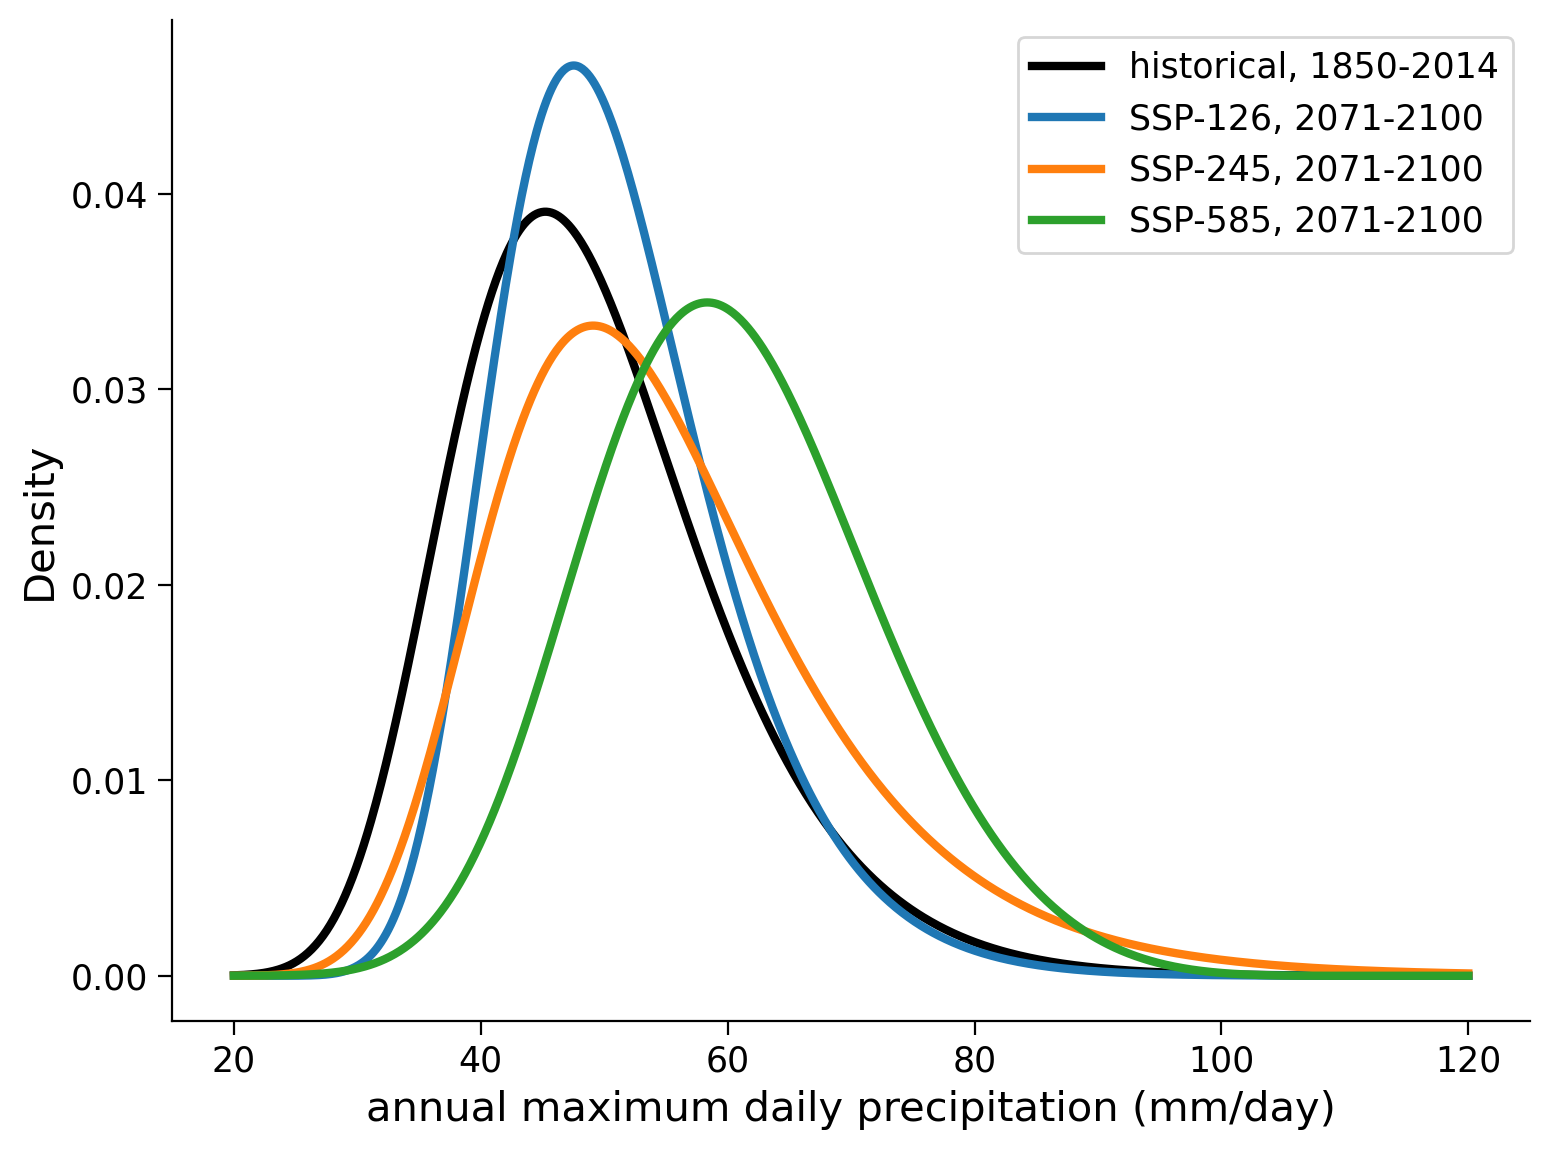

In [32]:
fig, ax = plt.subplots()
# x = np.linspace(293,302,1000)
x = np.linspace(20,120,1000)
ax.plot(x,gev.pdf(
    x, 
    shape_hist, 
    loc=loc_hist, 
    scale=scale_hist
    ),
    c='k',lw=3,label='historical, 1850-2014')
ax.plot(x,gev.pdf(
    x, 
    shape_ssp126, 
    loc=loc_ssp126, 
    scale=scale_ssp126
    ),
    c='C0',lw=3,label='SSP-126, 2071-2100')
ax.plot(x,gev.pdf(
    x, 
    shape_ssp245, 
    loc=loc_ssp245, 
    scale=scale_ssp245
    ),
    c='C1',lw=3,label='SSP-245, 2071-2100')
ax.plot(x,gev.pdf(
    x, 
    shape_ssp585, 
    loc=loc_ssp585, 
    scale=scale_ssp585
    ),
    c='C2',lw=3,label='SSP-585, 2071-2100')
ax.legend()
ax.set_xlabel('annual maximum daily precipitation (mm/day)')
ax.set_ylabel('Density')

In [33]:
parameters = pd.DataFrame(index=['Location', 'Scale', 'Shape'])
parameters['hist'] = [loc_hist, scale_hist, shape_hist]
parameters['ssp126'] = [loc_ssp126, scale_ssp126, shape_ssp126]
parameters['ssp245'] = [loc_ssp245, scale_ssp245, shape_ssp245]
parameters['ssp585'] = [loc_ssp585, scale_ssp585, shape_ssp585]

parameters = parameters.T
parameters.round(4)#.astype('%.2f')

,Location,Scale,Shape
hist,44.4731,9.4418,0.0777
ssp126,46.9651,7.9201,0.0690
ssp245,48.9565,11.0625,0.0133
ssp585,56.0055,10.9053,0.1969


In [34]:
fit_hist = fit_return_levels(data_hist,np.arange(1.1,200,0.1),N_boot=100,alpha=0.05)
fit_ssp126 = fit_return_levels(data_ssp126,np.arange(1.1,200,0.1),N_boot=100,alpha=0.05)
fit_ssp245 = fit_return_levels(data_ssp245,np.arange(1.1,200,0.1),N_boot=100,alpha=0.05)
fit_ssp585 = fit_return_levels(data_ssp585,np.arange(1.1,200,0.1),N_boot=100,alpha=0.05)

Location: 4.4e+01, scale: 9.4e+00, shape: 7.8e-02
Ranges with alpha=0.050 :
Location: [43.07 , 45.91]
Scale: [8.10 , 10.38]
Shape: [-0.02 , 0.19]
Location: 4.7e+01, scale: 7.9e+00, shape: 6.9e-02
Ranges with alpha=0.050 :
Location: [43.89 , 52.99]
Scale: [4.98 , 11.78]
Shape: [-0.50 , 0.71]
Location: 4.9e+01, scale: 1.1e+01, shape: 1.3e-02
Ranges with alpha=0.050 :
Location: [45.51 , 54.74]
Scale: [7.26 , 14.68]
Shape: [-0.37 , 0.43]
Location: 5.6e+01, scale: 1.1e+01, shape: 2.0e-01
Ranges with alpha=0.050 :
Location: [51.71 , 61.08]
Scale: [7.86 , 12.92]
Shape: [-0.05 , 0.48]


Text(0, 0.5, 'return level (mm/day)')

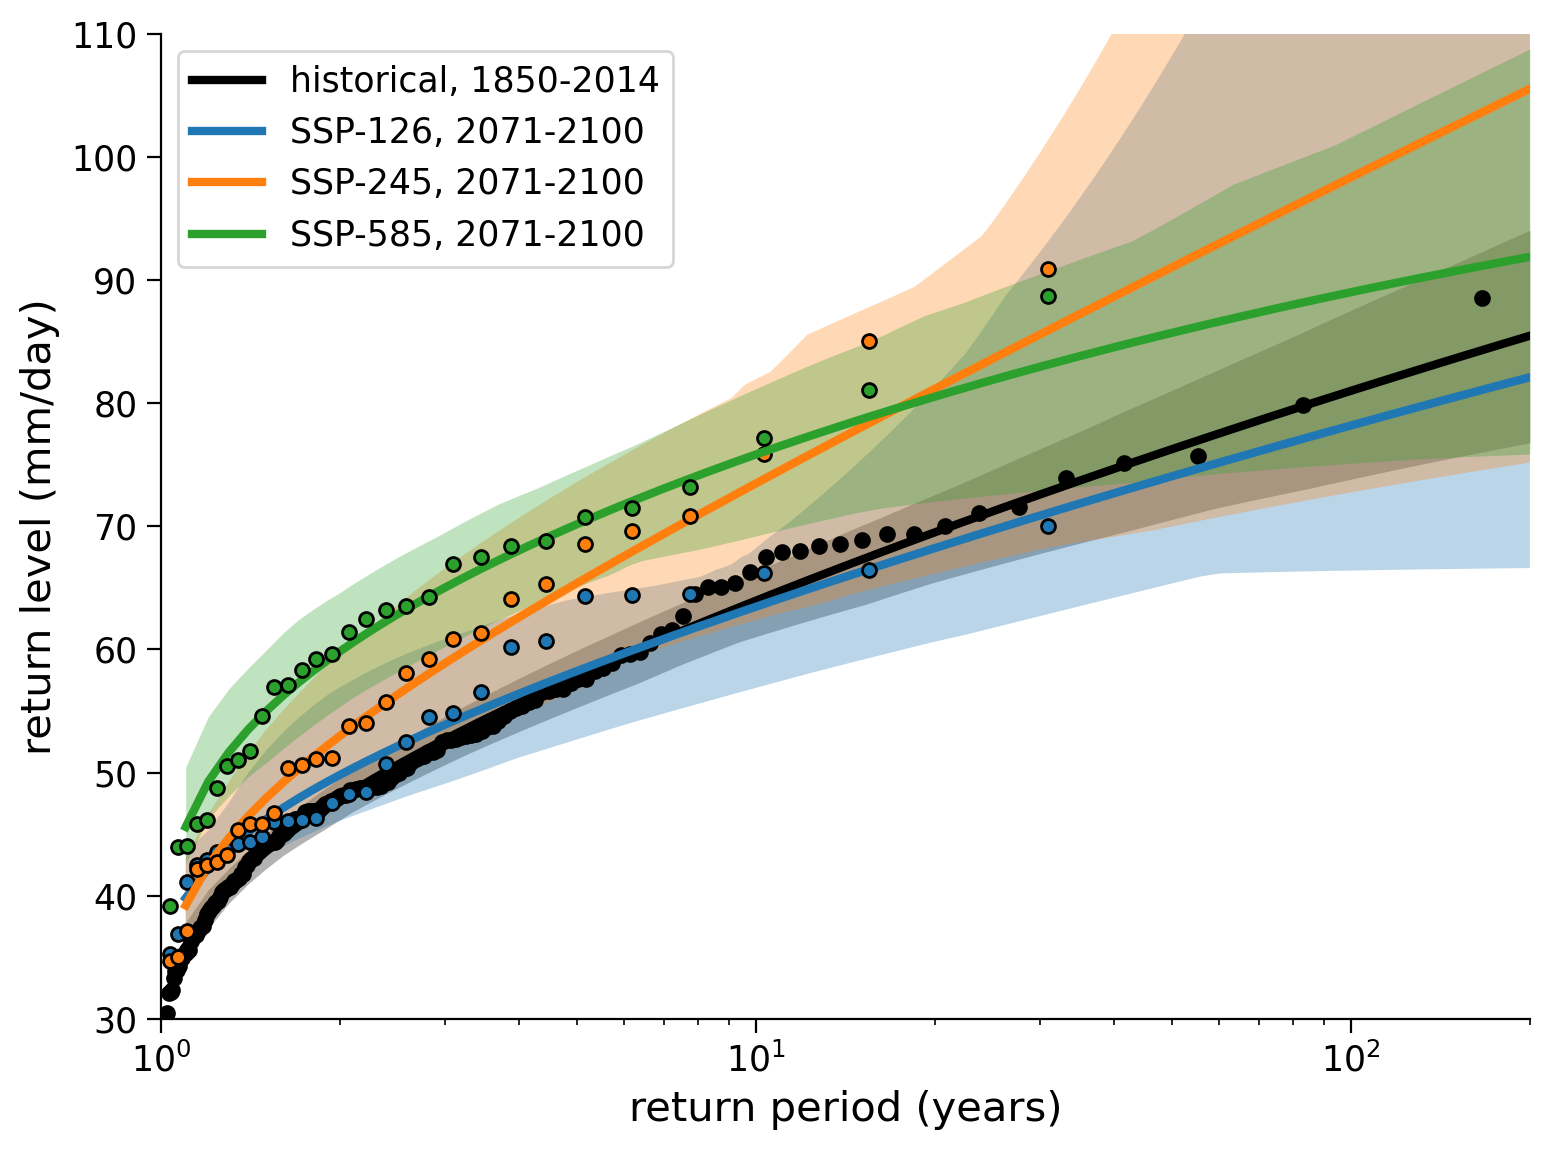

In [35]:
fig,ax=plt.subplots()
plot_return_levels(fit_hist,c='k',label='historical, 1850-2014',ax=ax)
plot_return_levels(fit_ssp126,c='C0',label='SSP-126, 2071-2100',ax=ax)
plot_return_levels(fit_ssp245,c='C1',label='SSP-245, 2071-2100',ax=ax)
plot_return_levels(fit_ssp585,c='C2',label='SSP-585, 2071-2100',ax=ax)
ax.set_xlim(1,200)
ax.set_ylim(30,110)
ax.set_xlabel('return period (years)')
ax.set_ylabel('return level (mm/day)')

## **Questions 4**

1. What can you say about how extreme precipitation differs between the climate scenarios? Are the differences large or small compared to periods in the historical records? What are the limitations? Consider the x-axis in the return-level plot compared to the space covered by the data (only 30 years). How could we get more information for longer return periods?

In [ ]:
# to_remove explanation
"""
The differences between the scenarios and the historical records are large for SSP 245 and SSP 558, while such difference is small for SSP 126. In general, we might expect larger differences as we move towards more extreme emission scenarios and further into the future. One limitation is the inherent uncertainty in any climate model. These models make assumptions about future emissions and other factors, which might not pan out exactly as predicted. Another limitation is the relatively short period covered by the data (only 30 years). To gain more information about longer return periods, you could use longer time series of data if available. 
"""

# **Summary**
In this tutorial, we've learned how to analyze climate model output to investigate the changes in extreme temperature and precipitation patterns over time under various emission scenarios. We've used historical data and simulated future scenarios to do this. Specifically, we've focused on three future Shared Socioeconomic Pathways (SSPs) scenarios, which represent potential futures based on different assumptions about greenhouse gas emissions.

We have also learned to use climate model outputs to assess changes during the historical period and compare potential future climate scenarios, specifically focusing on their impact on extreme events. We've explored how to fit Generalized Extreme Value (GEV) distributions to our data and use these fitted distributions to create return-level plots. These plots allow us to visualize the probability of extreme events under different climate scenarios.

By the end of this tutorial, we've gained a deeper understanding of how to utilize climate model outputs to evaluate the potential impacts of climate change, particularly focusing on extreme events.